In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
## Loading necessary modules and data
import os, sys
import time
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append(os.path.abspath(os.path.join('../..')))
sys.path.append(os.path.abspath(os.path.join('../../cobras_ts')))

from evaluation.clustering import recluster_with_interaction, store_cobras_result, recluster_without_interaction
from evaluation.evaluation import make_predictions_for_threshold
import util

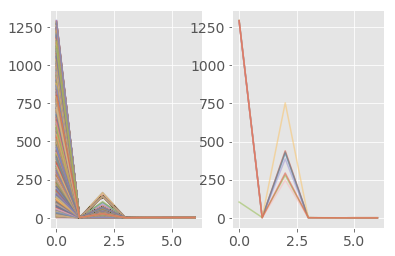

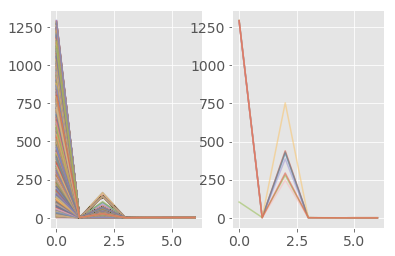

In [6]:
# First run the pipeline, so you have a segments_[beam]_[segment_score].csv file!
# Only put auto=True for testing purposes.
clusterer = recluster_with_interaction(budget=250, auto=False, filename='segments_B1_max2017.csv')
clustering, intermediate_clusterings, runtimes, ml, cl = clusterer.cluster()

In [7]:
# After clustering, ask for the cluster labeling.
labeling = clustering.construct_cluster_labeling()
#print(labeling)

Store this result as 'training data' for another phase of the algorithm where we do not want to cluster interactively



In [8]:
store_cobras_result('segments_B1_max2017', labeling)

| Write COBRAS result to file segments_B1_max2017_labeling.csv


## Re-use COBRAS clustering

In [35]:
previous_knowledge = 'segments_B1_max2017_labeling'
new_segments = 'segments_B1_max2018.csv'

In [36]:
segments = pd.read_csv(os.path.join(util.CERN_DIR, new_segments),index_col=0)

In [37]:
improved_prediction = recluster_without_interaction(segments, previous_knowledge)
improved_prediction = improved_prediction.drop(['url'],axis=1)

| Read training data for KNN from /Users/thiebout/master/anomaly-detection-mki-2019/src/../segments_B1_max2017_labeling.csv


In [38]:
improved_prediction.tail(10)

cluster_pred   nb    y_pred  freq_temp  min_freq_pressure  \
1436  1.0           118  0.011834  1.959973  -0.789085            
1437  1.0           63   0.026689  1.959973  -0.789085            
1438  1.0           2    0.006067  1.959973  -0.789085            
1439  3.0           547  0.023894 -0.590417  -0.541446            
1440  0.0           345  0.662971 -0.748173  -0.293808            
1441  0.0           848  0.292269  1.092314  -0.838613            
1442  3.0           117  0.008930  1.092314  -0.838613            
1443  0.0           268  1.000000 -0.511539  -0.145225            
1444  0.0           235  0.138819 -0.511539  -0.145225            
1445  3.0           453  0.024984 -0.511539  -0.145225            

      max_freq_pressure                  timestamp_min  \
1436 -0.789085           2018-12-02 21:46:29.088999987   
1437 -0.789085           2018-12-03 01:33:27.815000057   
1438 -0.789085           2018-12-03 01:44:07.989000082   
1439 -0.541446           2018-06-22 02:20:50.315999985   
1440 -0.293808           2018-08-30 00:17:35.371999979   
1441 -0.838613           2018-09-09 06:16:13.163000107   
1442 -0.838613           2018-09-10 01:24:57.513000011   
1443 -0.145225           2018-10-03 23:17:08.480999947   
1444 -0.145225           2018-10-06 14:16:22.015000105   
1445 -0.145225           2018-10-30 09:53:58.170000076   

                      timestamp_max  y_true  cluster_cobras  \
1436  2018-12-02 22:06:05.419000149  0.0     0                
1437  2018-12-03 01:43:54.986000061  0.0     0                
1438  2018-12-03 18:40:17.542000055  0.0     0                
1439  2018-06-23 03:45:34.858000040  1.0     1                
1440  2018-08-30 08:59:19.667999983  1.0     1                
1441  2018-09-09 15:11:13.730999947  1.0     1                
1442  2018-09-10 01:44:33.835999966  1.0     0                
1443  2018-10-04 21:31:07.881999969  1.0     1                
1444  2018-10-06 23:09:13.567000151  1.0     1                
1445  2018-10-31 05:17:48.789999962  1.0     1                

      cluster_pred_improved  
1436  1.0                    
1437  1.0                    
1438  1.0                    
1439  0.0                    
1440  0.0                    
1441  0.0                    
1442  1.0                    
1443  0.0                    
1444  0.0                    
1445  0.0

In [39]:
def cluster_to_prediction(row):
    if row['cluster_pred_improved'] in [0,3]:
        return 1
    else:
        return 0

In [40]:
improved_prediction['y_pred'] = improved_prediction.apply(lambda row: cluster_to_prediction(row), axis=1)

In [41]:
predictions_df, precision, recall, tp, fp, fn, tn = make_predictions_for_threshold(improved_prediction, .99, 'y_pred')

In [42]:
print('precision: ', precision)
print('recall: ', recall)

print('TP: {} | FP: {}'.format(tp, fp))
print('FN: {} | TN: {}'.format(fn, tn))

precision:  0.75
recall:  0.8571428571428571
TP: 6 | FP: 2
FN: 1 | TN: 1437


## Visualisation

In [43]:
def print_confusion_matrix(df, col):
    TP = len(improved_prediction.loc[df[col]==0])
    TN = len(improved_prediction.loc[df[col]==1])
    FP = len(improved_prediction.loc[df[col]==2])
    FN = len(improved_prediction.loc[df[col]==3])

    print('TP: {} | FP: {}'.format(TP, FP))
    print('FN: {} | TN: {}'.format(FN, TN))

In [61]:
def plot_segments(df, col):
    plt.figure()
    pred = df['y_pred']
    nb = df['nb']
    cluster = df[col]
    norm = matplotlib.colors.Normalize(vmin=0,vmax=3)
    cmap = "seismic"
    sc = plt.scatter(x=pred,y=nb,c=cluster,cmap=cmap,norm=norm)

    size = 81
    lp = lambda i: plt.plot([],color=sc.cmap(sc.norm(i)), ms=np.sqrt(size), mec="none",
                            label="{}".format(util.num_to_pred(i)), ls="", marker="o")[0]
    handles = [lp(i) for i in np.unique(cluster)]
    ax = plt.gca()
    
    plt.legend(handles=handles)
    plt.xlabel('Anomaly score')
    plt.ylabel('Nb of tuples in segment')
    plt.show()

### Compare to the original result

In [49]:
print_confusion_matrix(improved_prediction, 'cluster_pred')

TP: 4 | FP: 11
FN: 3 | TN: 1428


In [62]:
plot_segments(improved_prediction, 'cluster_pred')